# HEART RATE ESTIMATION

## Introduction:

Seismocardiography(SCG) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them.

MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG.

The dataset used (**center_sternum.txt**) provide measurments acquired on a subject who was lying supine on his left and right side, respectively. MuSe  is placed on the center of the sternum

## Libraries:

The main libraries used to perform SCG are the following:

1. **Pandas**: to collect the dataset as DataFrame and select the columns of interest. 
* **Numpy**: to perform operations with arrays and use some usefull tools
* **Matplotlib**: to plot the resuls 
* **Seaborn**: to have a nice design of the plotted results 
* **Scipy**: to perform some numerical routines, such as linear algebra and statistics.
* **PyWavelets**: to perform wevelet filtering.

In [1]:
######  LIBRARIES  #######
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft, ifft, stats
from scipy.signal import welch, butter, filtfilt, find_peaks
import pywt
import seaborn as sns
import matplotlib


## Data preparation:

In this first part the dataset is loaded as DataFrame. The columns of interest are selected to do a complete data analysis. A "Time" column is added. This one will be usefull in the last part of the project to understand at which time a heart beat occurs. 

The selected data are then plotted. These are the three components of both the Accelerometer and Gyroscope. Thanks to these plots we are able to have an opening view of how these signals look like. Moreover a very noisily area at the begin and at the end of those signals can be detected. As consequence the signals are then cutted to select just the central part. These part correspond to exactly 60 seconds of data collections. 

1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

In [2]:
# Data import
file_name = "center_sternum.txt"

# creation of a DataFrame containing the whole dataset
df_sternum = pd.DataFrame(pd.read_csv(file_name, sep = "\t", header = 0))

# select just the column of interest
df_sternum = df_sternum.iloc[:,[1,3,4,5,6,7,8]]

# recover the samples frequency
freq = df_sternum['Log Freq'][0]

# create the time vector
time = np.arange(0, len(df_sternum)* 1/freq, 1/freq)

# create the AccX, AccY, AccZ ,GyroX, GyroY, GyroZ vectors
accX, accY, accZ = df_sternum['AccX'][:], df_sternum['AccY'][:], df_sternum['AccZ'][:]
gyroX,gyroY,gyroZ = df_sternum['GyroX'][:], df_sternum['GyroY'][:], df_sternum['GyroZ'][:]

# insert time column
df_sternum.insert(1, "Time", time)

# print data
df_sternum.head()


,Log Freq,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,200,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580
1,200,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466
2,200,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382
3,200,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733
4,200,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267


2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

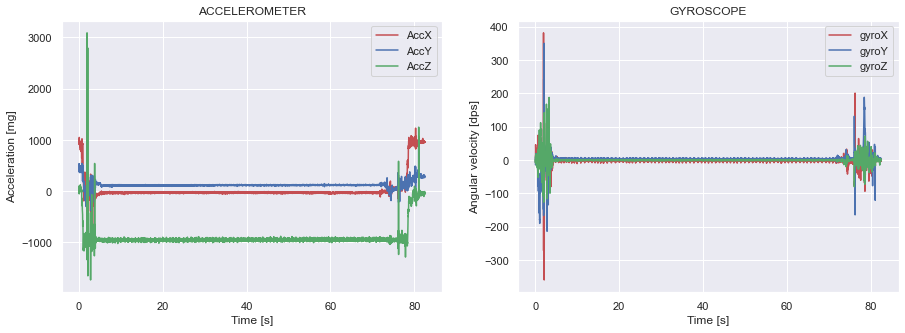

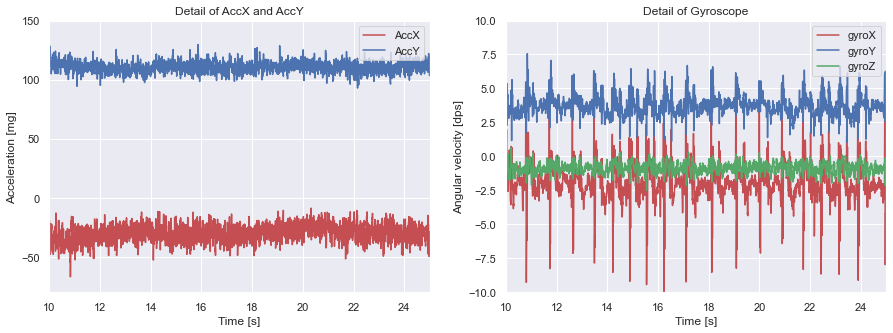

In [3]:
# Data plotting
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
# create the subplots 
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot the accelerometer's data
axis[0].plot(time,accX,'r',label = 'AccX')
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].plot(time,accZ,'g',label = 'AccZ')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('ACCELEROMETER')
axis[0].legend(loc = 1)

#plot the gyroscope's data
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('GYROSCOPE')
axis[1].legend(loc = 1)
#plt.savefig("Images/SCG/data.png")

# create the subplots for a detail of the previous ones
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot a detail of the accelerometer plot
axis[0].plot(time,accX,'r',label = 'AccX')
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('Detail of AccX and AccY')
axis[0].set_ylim([-80,150])
axis[0].set_xlim([10,25])
axis[0].legend(loc = 1)

# plot a detail of the gyroscope plot
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('Detail of Gyroscope')
axis[1].set_ylim([-10,10])
axis[1].set_xlim([10,25])
axis[1].legend(loc = 1)
#plt.savefig("Images/SCG/data2.png")

plt.show()


In [4]:
# select interval of interest to avoid the large amount of noise at the beginning and at the end of the original
# signal
df_sternum = df_sternum[(df_sternum['Time'] >= 10) & (df_sternum['Time'] < 70)]

# update accX, accY, accZ, gyroX, gyroY, gyroZ according to the new interval of interest
time = np.arange(0, len(df_sternum)* 1/freq, 1/freq)
accX, accY, accZ = df_sternum['AccX'][:], df_sternum['AccY'][:], df_sternum['AccZ'][:]
gyroX, gyroY, gyroZ = df_sternum['GyroX'][:], df_sternum['GyroY'][:], df_sternum['GyroZ'][:]


3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

**PCA** (Principal Component Analysis) is a dimensionality reduction technique. It's used to extract relevant information in a big confusing dataset. The goal of PCA is to find a new basis to re-express a dataset in order to reveal interesting stucture.

The central idea of PCA is to find out redudancy between variables and remove it as much as possibile. The main steps of PCA are the following: 
1. Compute the data mean vector from the data matrix X. 
* Subtract off mean vector from the dataset.
* Calculate the sample covariance matrix Cx.
* Calculate eigenvectors of matrix Cx in order to obtain the matrix P (new base).
* Apply the change of base PX = Y. Y will be the tranformed data matrix, if digonal, is uncurrelated and so we won't have any redundacy.


**PCA for Accelerometer**

In this section the PCA is used over the three components of the Accelerometer. 

As consequence of the results, a new base is apply to the data matrix and we reduce it from three to two dimensions. This operation allow us to keep and amount of 91% of information from the original matrix.

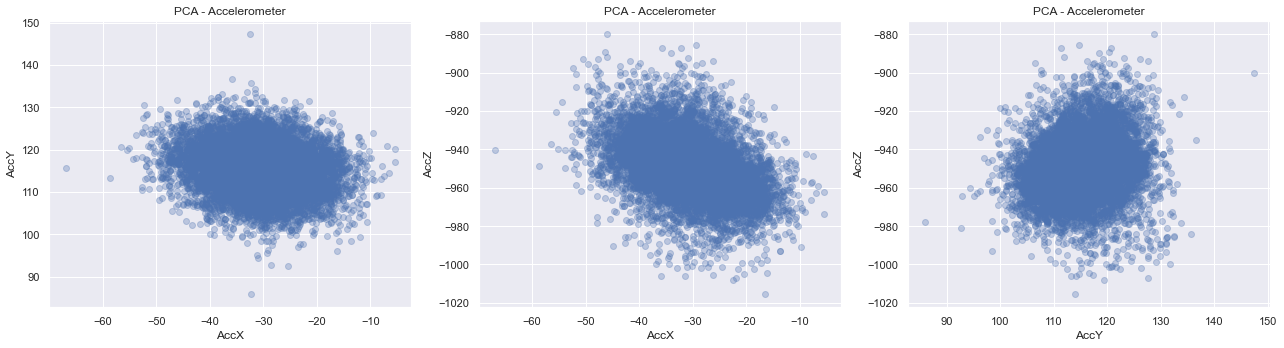

In [5]:
# create the matrix for the PCA technique, in the rows there are the AccX, AccY, AccZ measurments, and each 
# column represents a data sample

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
X_acc = np.array([accX, accY, accZ])

figure, axis = plt.subplots(1,3, figsize = (18,5))
axis[0].scatter(X_acc[0,:], X_acc[1,:], alpha=0.3, color = 'b')
axis[0].set_xlabel('AccX')
axis[0].set_ylabel('AccY')
axis[0].set_title('PCA - Accelerometer')
axis[1].scatter(X_acc[0,:], X_acc[2,:], alpha=0.3, color = 'b')
axis[1].set_xlabel('AccX')
axis[1].set_ylabel('AccZ')
axis[1].set_title('PCA - Accelerometer')
axis[2].scatter(X_acc[1,:], X_acc[2,:], alpha=0.3, color = 'b')
axis[2].set_xlabel('AccY')
axis[2].set_ylabel('AccZ')
axis[2].set_title('PCA - Accelerometer')
figure.tight_layout()
#plt.savefig("Images/SCG/PCA_acc.png")

plt.show()


[[218.52   0.     0.  ]
 [  0.    39.8    0.  ]
 [  0.     0.    26.45]] 

Trace of the original data matrix:  284.76
Trace of the data matrix after the changes of base:  284.77 

Fraction of the total variability keeping only the first principal component:  77.0 %
Fraction of the total variability keeping only the first two principal components:  91.0 %
Fraction of the total variability keeping only the last two principal components:  23.0 %


/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


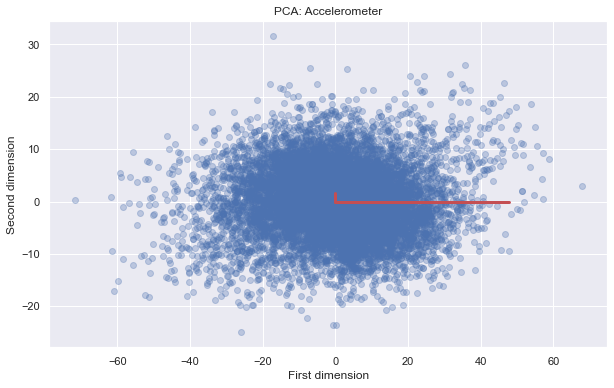

In [6]:
# compute the mean of X and subtract it to obtain a zero main matrix X
X_acc = X_acc - X_acc.mean()

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covariance matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_acc))
#P = V.T
#Cy = P.dot(np.cov(X_acc)).dot(P.T)
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")


# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_acc).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first two principal components: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the last two principal components: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")

# as consequence of the PCA technique keeping the two principal components for the Accelerometer is better
# the eigenvectors are in the columns of V
P = V[:,0:2]

PCA_acc = P.T.dot(X_acc) # new data according to PCA result

#Visualize the original data projected into the new space with the relative principal axis
scale_factor = 0.001
first_dim = PCA_acc[0] - PCA_acc[0].mean()
second_dim = PCA_acc[1] - PCA_acc[1].mean()
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
plt.figure(figsize=(10,6))
plt.scatter(first_dim, second_dim, alpha=0.3, c = 'b')
plt.plot([0, scale_factor*l[0]*np.cov(PCA_acc)[0,0]], [0, scale_factor*l[0]*np.cov(PCA_acc)[1,0]], 'r', lw=3)
plt.plot([0, scale_factor*l[1]*np.cov(PCA_acc)[0,1]], [0, scale_factor*l[1]*np.cov(PCA_acc)[1,1]], 'r', lw=3)
plt.title('PCA: Accelerometer')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
#plt.savefig("Images/SCG/PCA_acc2.png")

plt.show()


**PCA for Gyroscope**

In this section the PCA is used over the three components of the Gyroscope. 

As consequence of the results, a new base is apply to the data matrix and we reduce it from three to two dimensions. This operation allow us to keep and amount of 96% of information from the original matrix.

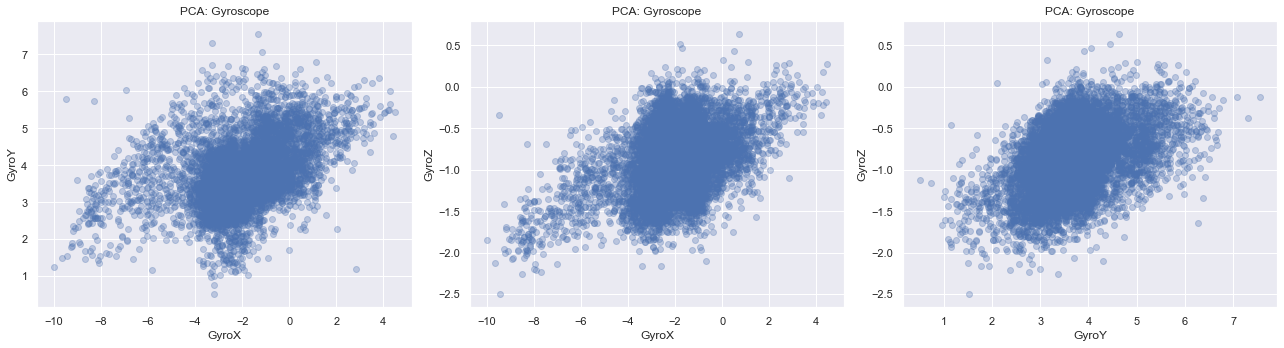

In [7]:
X_gyro = np.array([gyroX, gyroY, gyroZ]) 
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
figure, axis = plt.subplots(1,3, figsize = (18,5))
axis[0].scatter(X_gyro[0,:], X_gyro[1,:], alpha=0.3, color = 'b')
axis[0].set_xlabel('GyroX')
axis[0].set_ylabel('GyroY')
axis[0].set_title('PCA: Gyroscope')
axis[1].scatter(X_gyro[0,:], X_gyro[2,:], alpha=0.3, color = 'b')
axis[1].set_xlabel('GyroX')
axis[1].set_ylabel('GyroZ')
axis[1].set_title('PCA: Gyroscope')
axis[2].scatter(X_gyro[1,:], X_gyro[2,:], alpha=0.3, color = 'b')
axis[2].set_xlabel('GyroY')
axis[2].set_ylabel('GyroZ')
axis[2].set_title('PCA: Gyroscope')
figure.tight_layout()
#plt.savefig("Images/SCG/PCA-gyro.png")

plt.show()

[[2.12 0.   0.  ]
 [0.   0.42 0.  ]
 [0.   0.   0.1 ]] 

Trace of the original data matrix:  2.64
Trace of the data matrix after the changes of base:  2.64 

Fraction of the total variability keeping only the first principal component:  80.0 %
Fraction of the total variability keeping only the first two principal components:  96.0 %
Fraction of the total variability keeping only the last two principal components:  20.0 %


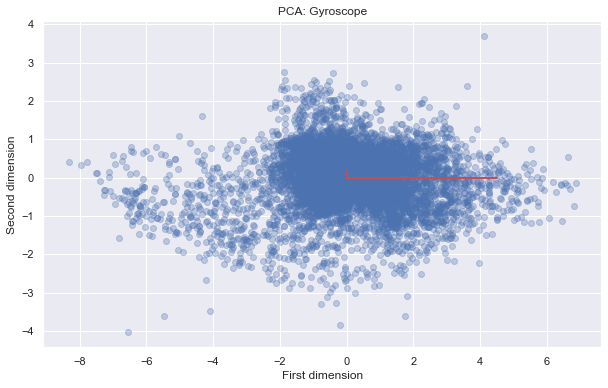

In [8]:
#compute the mean of X and subtract it to obtain a zero main matrix X
X_gyro = X_gyro - X_gyro.mean()

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covarinace matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_gyro))
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")

# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_gyro).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first two principal components: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the last two principal components: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")

# as consequence of the PCA technique keeping the two principal components for the Gyroscope is better
P = V[:,0:2] #the eigenvectors are in the columns of V

# new data according to PCA result
PCA_gyro = P.T.dot(X_gyro) 

#Visualize the original data projected into the new space with the relative principal axis
first_dim = PCA_gyro[0] - PCA_gyro[0].mean()
second_dim = PCA_gyro[1] - PCA_gyro[1].mean()
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
plt.figure(figsize=(10,6))
plt.scatter(first_dim, second_dim, alpha=0.3, c = 'b')
plt.plot([0, l[0]*np.cov(PCA_gyro)[0,0]], [0, l[0]*np.cov(PCA_gyro)[1,0]], 'r', lw=2)
plt.plot([0, l[1]*np.cov(PCA_gyro)[0,1]], [0, l[1]*np.cov(PCA_gyro)[1,1]], 'r', lw=2)
plt.title('PCA: Gyroscope')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
#plt.savefig("Images/SCG/PCA-gyro2.png")

plt.show()


## Time and frequency analysis:

1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.


In [9]:
# Create dataframe with the component obtained from PCA
A = [PCA_acc[0].reshape(len(PCA_acc[0]), 1), PCA_acc[1].reshape(len(PCA_acc[1]), 1), PCA_gyro[0].reshape(len(PCA_gyro[0]), 1), PCA_gyro[1].reshape(len(PCA_gyro[1]), 1)]
A = np.array(A).reshape(len(PCA_acc[0]), 4)
df_PCA = pd.DataFrame(data = A)
df_PCA.insert(0, "Time", time)

# compute statistics
df_PCA = df_PCA.describe()
df_PCA = df_PCA.rename(columns={"Time": "Time [s]", 0 : "AccX [mg]", 1: "AccY [mg]", 2: "GyroX [rad/s]", 3: "GyroY [rad/s]"})
df_PCA.round(1)
stat = df_PCA.iloc[:,1:].round(1) 

stat


,AccX [mg],AccY [mg],GyroX [rad/s],GyroY [rad/s]
count,12000.0,12000.0,12000.0,12000.0
mean,174.0,174.1,174.0,174.1
std,287.7,287.8,287.6,287.7
min,-9.5,-8.8,-9.3,-9.8
25%,-2.9,-2.9,-2.9,-2.9
50%,7.0,5.6,6.4,5.3
75%,194.1,191.9,194.2,198.6
max,739.5,728.8,730.5,728.5


2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 


<ipython-input-10-ab94fa055c6b>:4: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  fft_values_ = fft(y_values)


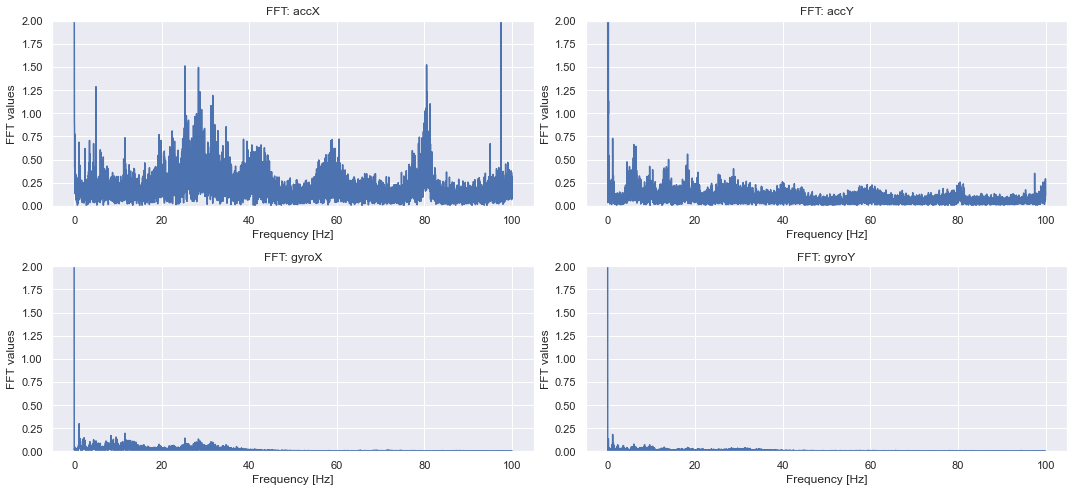

In [10]:
# define fft and psd function
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)      
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])     
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

N = df_sternum.shape[0]
T = 1/freq   
f_s = freq   

# compute fft
f_accX, fft_accX = get_fft_values(np.array(PCA_acc[0]), T, N, f_s)
f_accY, fft_accY  = get_fft_values(np.array(PCA_acc[1]), T, N, f_s)
f_gyroX, fft_gyroX = get_fft_values(np.array(PCA_gyro[0]), T, N, f_s)
f_gyroY, fft_gyroY = get_fft_values(np.array(PCA_gyro[1]), T, N, f_s)

# plot fft results
figure, axis = plt.subplots(2, 2, figsize = (15, 7))
axis[0, 0].plot(f_accX, fft_accX)
axis[0, 0].set_ylim([0, 2])
axis[0, 0].set_xlabel('Frequency [Hz]')
axis[0, 0].set_ylabel('FFT values')
axis[0, 0].set_title('FFT: accX')
axis[0, 1].plot(f_accY, fft_accY)
axis[0, 1].set_ylim([0, 2])
axis[0, 1].set_xlabel('Frequency [Hz]')
axis[0, 1].set_ylabel('FFT values')
axis[0, 1].set_title('FFT: accY')
axis[1, 0].plot(f_gyroX, fft_gyroX)
axis[1, 0].set_ylim([0, 2])
axis[1, 0].set_xlabel('Frequency [Hz]')
axis[1, 0].set_ylabel('FFT values')
axis[1, 0].set_title('FFT: gyroX')
axis[1, 1].plot(f_gyroY, fft_gyroY)
axis[1, 1].set_ylim([0, 2])
axis[1, 1].set_xlabel('Frequency [Hz]')
axis[1, 1].set_ylabel('FFT values')
axis[1, 1].set_title('FFT: gyroY')
figure.tight_layout()
#plt.savefig("Images/SCG/FFT.png")

plt.show()


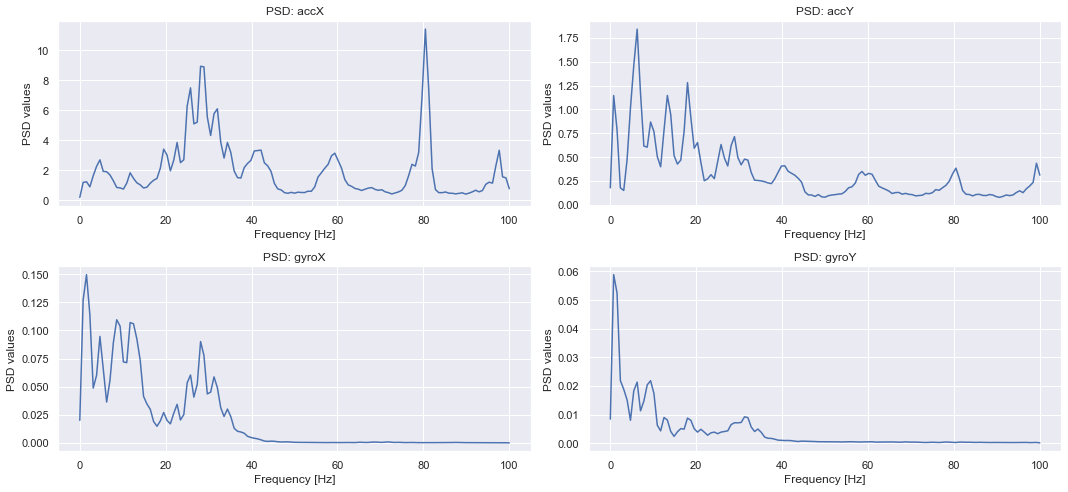

In [11]:
# compute psd results
f_accX_psd, fft_accX_psd = get_psd_values(np.array(PCA_acc[0]), T, N, f_s)
f_accY_psd, fft_accY_psd  = get_psd_values(np.array(PCA_acc[1]), T, N, f_s)
f_gyroX_psd, fft_gyroX_psd = get_psd_values(np.array(PCA_gyro[0]), T, N, f_s)
f_gyroY_psd, fft_gyroY_psd = get_psd_values(np.array(PCA_gyro[1]), T, N, f_s)

# plot psd results
figure, axis = plt.subplots(2, 2, figsize = (15, 7))
axis[0, 0].plot(f_accX_psd, fft_accX_psd)
axis[0, 0].set_xlabel('Frequency [Hz]')
axis[0, 0].set_ylabel('PSD values')
axis[0, 0].set_title('PSD: accX')
#axis[0, 0].set_ylim([0, 2])
axis[0, 1].plot(f_accY_psd, fft_accY_psd)
axis[0, 1].set_xlabel('Frequency [Hz]')
axis[0, 1].set_ylabel('PSD values')
axis[0, 1].set_title('PSD: accY')
#axis[0, 1].set_ylim([0, 2])
axis[1, 0].plot(f_gyroX_psd, fft_gyroX_psd)
axis[1, 0].set_xlabel('Frequency [Hz]')
axis[1, 0].set_ylabel('PSD values')
axis[1, 0].set_title('PSD: gyroX')
#axis[1, 0].set_ylim([0, 2])
axis[1, 1].plot(f_gyroY_psd, fft_gyroY_psd)
axis[1, 1].set_xlabel('Frequency [Hz]')
axis[1, 1].set_ylabel('PSD values')
axis[1, 1].set_title('PSD: gyroY')
#axis[1, 1].set_ylim([0, 2])
figure.tight_layout()
#plt.savefig("Images/SCG/PSD.png")

plt.show()


From the above PSD plots we can see the first two principal components of acceleration signals have high densities of power outside our band of interest, so we choose the first gyro component to be filtered, since it shows more power in the low frequency (heart beat) region.

**Filter:**
    
Now we try three different approaches for filtering the signal 
    
   (1) Directly in the frequency domain by zeroing the FT coefficient related to frequencies outside the band of interest           of [40,100] BPM, then antitrasforming
    
   (2) Butterworth Bandpass filter with the same BPM range
    
   (3) Multilevel Wavelet trasform  

Here we define the filtering functions

In [12]:
# define the 3 filters 
def fftfilt(x,lf,hf,fs):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x),1/fs)
    X_filt = np.array([X[i] if (f[i] >= lf and f[i] <= hf) else 0 for i in range(0,len(X))]) # set to 0 the frequencies outside the BPM range
    x_filt = np.fft.irfft(X_filt)
    return x_filt

def butterfilt(x, lf, hf, fs):
    b,a = butter(4,[lf,hf], btype='bandpass', fs=fs)
    x_filt = filtfilt(b,a, x)  
    return x_filt 

def wave_dec(data, w,levels):

    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(levels):
        a, d = pywt.dwt(a, w)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig1 = plt.figure(figsize=(20,10))
    ax_main = fig1.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title("WAVELET DECOMPOSITION - Original signal", fontsize = 16)
    data = np.array(data) 
    ax_main.plot(time,data)
    ax_main.set_xlim(35,40)
    ax_main.set_xlabel("Time [s]")
    #plt.savefig("Images/SCG/dec1.png")
    fig = plt.figure(figsize=(20,10))
    #ax_main.set_xlim(0, len(data) - 1)
    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) +1, 2, 3 + i * 2)
        ax.plot(time,y[:len(time)], 'r')
        #ax.set_xlim(0, len(y) - 1)
        ax.set_xlim(30,40)
        ax.set_title("Approx%d" % (i + 1))
        ax.set_xlabel("Time [s]")

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) +1, 2, 4 + i * 2)
        ax.plot(time,y[:len(time)], 'g')
        #ax.set_xlim(0, len(y) - 1)
        ax.set_xlim(30,40)
        ax.set_title("Detail%d" % (i + 1))
        ax.set_xlabel("Time [s]")
    figure.tight_layout()
    #plt.savefig("Images/SCG/dec2.png")
    return rec_a,rec_d,ca,cd


We set the low and high frequency cutoffs for passband filtering and the parameters for wavelet decomposition

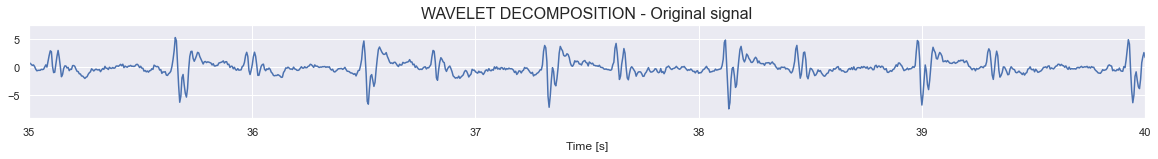

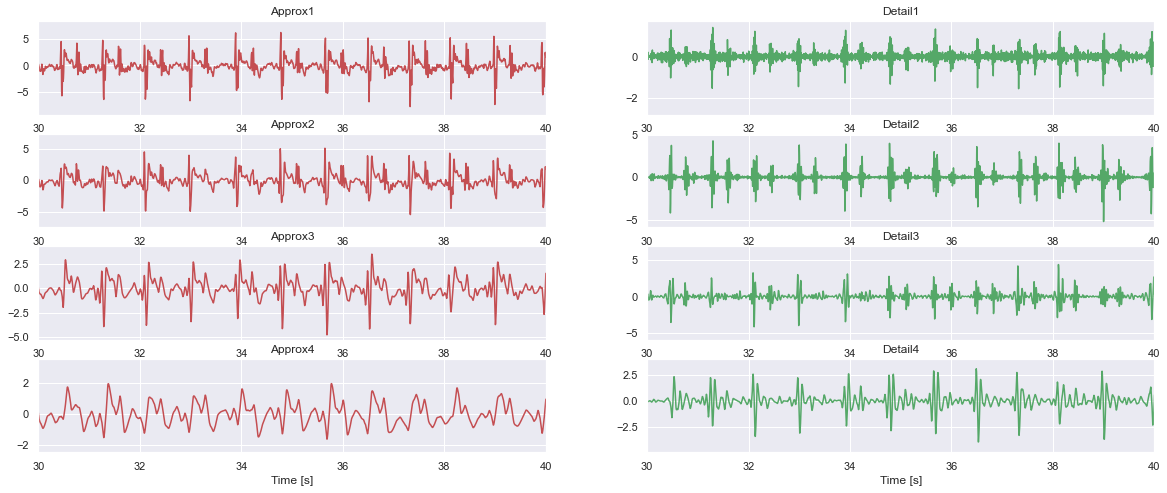

In [13]:
# Normalize
selected = (PCA_gyro[0]-np.mean(PCA_gyro[0]))
fs = freq
lf = 40/60 #low band limit 40 bmp to Hz
hf = 100/60  #high band limit 100 bmp to Hz
wavelet = "sym4"
levels = 4

sig_filt_fft = fftfilt(selected,lf,hf,fs)
sig_filt_butter = butterfilt(selected,lf,hf,fs)
rec_a,rec_d,ca,cd = wave_dec(selected, wavelet,levels)

After applying a threshold to the DWT coefficient we reconstruct the original signal by inverse DWT

In [14]:
# reconstruct the signals
threshold = 2

coeffs = []
coeffs.append(pywt.threshold(ca[-1],np.sqrt(threshold*np.log2(ca[-1].size))))
[coeffs.append(pywt.threshold(cdx,np.sqrt(threshold*np.log2(cdx.size)))) for cdx in reversed(cd)]
wavelet_filt = pywt.waverec(coeffs, wavelet)


**Filtered signals**

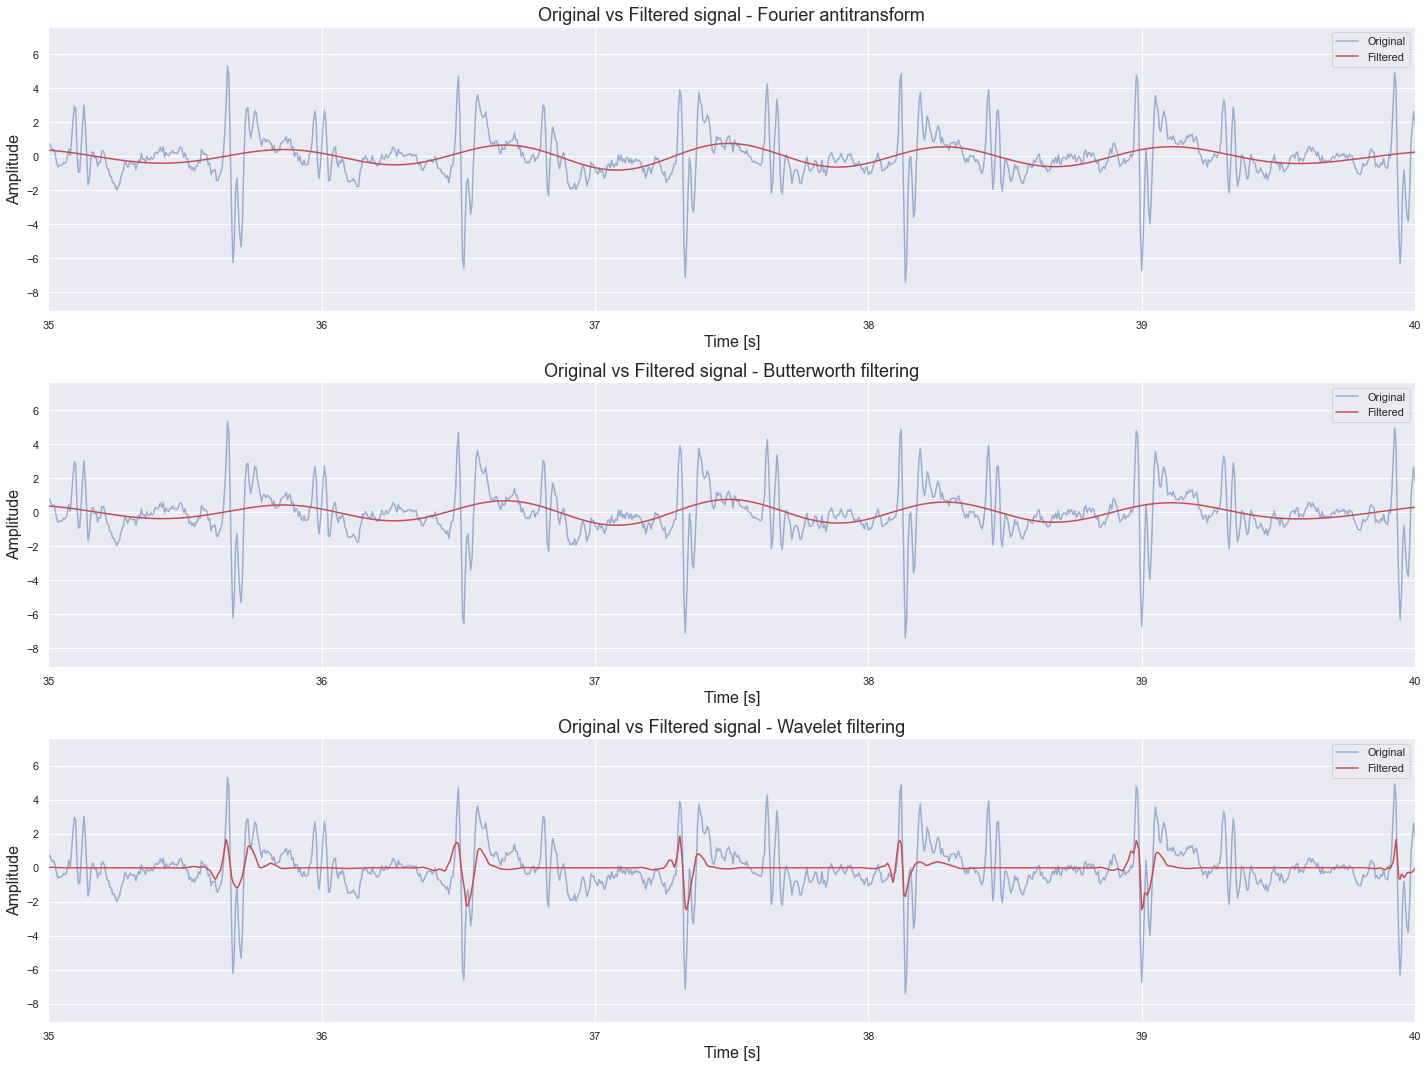

In [15]:
# Plot the filter results
figure, axis = plt.subplots(3, 1, figsize = (20, 15))

axis[0].plot(time, selected, 'b', alpha = 0.5, label = 'Original')
axis[0].plot(time, sig_filt_fft, 'r', label = 'Filtered')
axis[0].set_xlim([35,40])
axis[0].set_title("Original vs Filtered signal - Fourier antitransform", fontsize = 18)
axis[0].set_xlabel('Time [s]', fontsize = 16)
axis[0].set_ylabel('Amplitude', fontsize = 16)
axis[0].legend()
axis[1].plot(time, selected, 'b', alpha = 0.5, label = 'Original')
axis[1].plot(time, sig_filt_butter, 'r', label = 'Filtered')
axis[1].set_xlim([35,40])
axis[1].set_title("Original vs Filtered signal - Butterworth filtering", fontsize = 18)
axis[1].set_xlabel('Time [s]', fontsize = 16)
axis[1].set_ylabel('Amplitude', fontsize = 16)
axis[1].legend()
axis[2].plot(time, selected, 'b', alpha = 0.5, label = 'Original')
axis[2].plot(time, wavelet_filt[len(wavelet_filt)-len(time):], 'r', label = 'Filtered')
axis[2].set_xlim([35,40])
axis[2].set_title("Original vs Filtered signal - Wavelet filtering", fontsize = 18)
axis[2].set_xlabel('Time [s]', fontsize = 16)
axis[2].set_ylabel('Amplitude', fontsize = 16)
axis[2].legend()
figure.tight_layout()
# plt.savefig("Images/SCG/Original_filt.png")

plt.show()


From the results of FT analysis and by visual inspection of the signal in time we can note the beat signal has a wide spectrum, so we can expect that a simple passband filtering would distort and smoothen the beat shape, making it harder to  accurately detect the peaks. These intuitions are confirmed by the plots above, where we can see that the heartbeat signal with its high frequency spectrum removed becomes a sine wave.

We then try a multilevel wavelet transform filtering and plot the approximation and details signal for each of the 5 decomposition levels.

**Peaks detection**

For detecting the peaks in the filtered signal we make use of the find_peaks from scipy.signal, which is instructed to consider only peaks spaced apart by an amount of samples given by $\frac{f_{sampling}}{f_{HRmax}}$ where $f_{HRmax} = \frac{100(BPM)}{60}$

In [16]:
# find peaks
peaks_fft,_ = find_peaks(sig_filt_fft, height=0.2, threshold=None, distance=fs/hf, prominence=0.4, width=None, wlen=None, rel_height=0.5, plateau_size=None)
peaks_butt,_ = find_peaks(sig_filt_butter, height=0.2, threshold=None, distance=fs/hf, prominence=0.4, width=None, wlen=None, rel_height=0.5, plateau_size=None)
peaks_wavelet,_ = find_peaks(np.abs(wavelet_filt), height=0.5, threshold=None, distance=fs/hf, prominence=None, width=None, wlen=None, rel_height=None, plateau_size=None)

**Results of peak detection**

We now plot the detected peaks (blue dots) against the original signal to visually assess the beat detector performances.

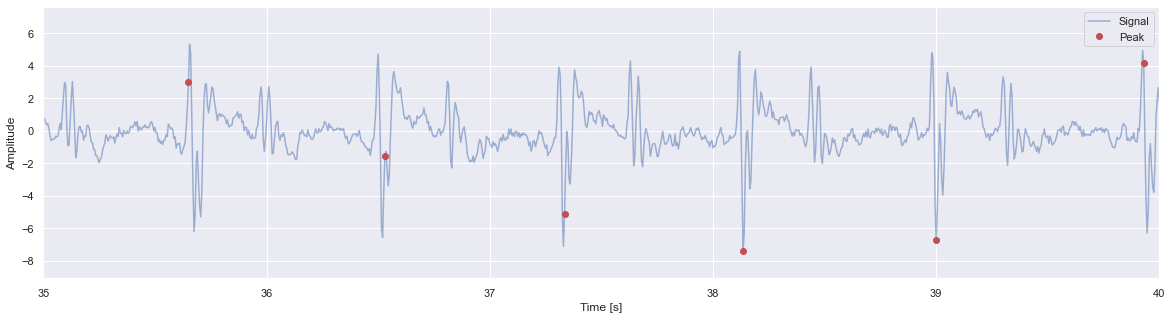

In [17]:
# plot peak detection
fig = plt.figure(figsize=(20, 5))
plt.plot(time, selected, 'b',alpha=0.5, label = "Signal")
plt.plot(time[peaks_wavelet], selected[peaks_wavelet], 'o', color = 'r', label = "Peak")
plt.legend(loc="upper right")
ax = fig.get_axes()
ax[0].set_xlim([35,40]);
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude')
#plt.savefig("Images/SCG/Peak.png")

plt.show()


We can see that every beat is correctly detected even if the exact location of the peak is not always precise

**Metrics:**

We now extrapolate the average BPM by dividing the number of found peaks by the length of the whole recording period.

Then we also calculate the HRV, which is the standard deviation of the inverse of the time differences between peaks.
The HRV metric can be useful to assess the quality of the detector since we expect that an idle heathy person would have a regular heartbeat, without any a priori knowledge on the person, an high HRV might also be due to arrhythmias. 
    

In [18]:
# compute and show the metrics
print("mean BPM with FFT filt = ",len(peaks_fft)*60/(len(sig_filt_fft)/fs))
print("mean BPM with butterworth filt = ",len(peaks_butt)*60/(len(sig_filt_butter)/fs))
print("mean BPM with wavelet filt = ",len(peaks_wavelet)*60/(len(wavelet_filt)/fs))
print("HRV with FFT filt = ",np.std(60/(np.diff(peaks_fft)/freq)))
print("HRV with butterworth filt = ",np.std(60/(np.diff(peaks_butt)/freq)))
print("HRV with wavelet filt = ",np.std(60/(np.diff(peaks_wavelet)/freq)))


mean BPM with FFT filt =  69.0
mean BPM with butterworth filt =  67.0
mean BPM with wavelet filt =  69.0
HRV with FFT filt =  7.256418464724548
HRV with butterworth filt =  8.18015426442888
HRV with wavelet filt =  6.87938060005586


In spite of the above considerations on the three filtering methods, the calculated BPM and HRV values are almost identical; 

 

**Curve fit**

We plot an histogram of the instantaneous BPM, based on the period intercurring between two beats and try to fit it in a gamma distribution.

Gamma fitting parameters:
Mean BPM =  70.36843625068528
HRV =  6.721935429607751


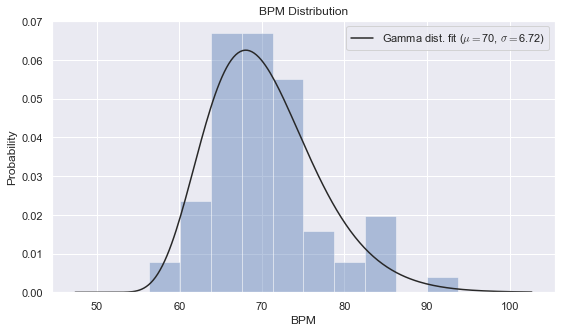

In [19]:
# plot histogram of results and fit it to compute bpm and hrv
plt.rcParams['figure.figsize']=(9 ,5)
beat_indexes = peaks_wavelet
bpms = 60/(np.diff(beat_indexes)/fs)
ax = sns.distplot(bpms,kde=False, bins = 10,fit=stats.gamma);
ax.set_title('BPM Distribution')
ax.set(xlabel='BPM', ylabel='Probability')
param = stats.gamma.fit(bpms)
mu = stats.gamma.mean(param[0],param[1],param[2])
sigma = stats.gamma.std(param[0],param[1],param[2])
plt.legend(["Gamma dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
print("Gamma fitting parameters:")
print("Mean BPM = ", mu)
print("HRV = ",sigma)
#plt.savefig("Images/SCG/fitting.png")

plt.show()
